In [27]:
#import pandas as pd
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime
import json
import os
import matplotlib.pyplot as plt
import pickle

#from tslearn.utils import to_time_series_dataset
#from tslearn.clustering import TimeSeriesKMeans

from sktime.clustering.k_means import TimeSeriesKMeans

import warnings
warnings.filterwarnings('ignore')

fase = '02b_DTW'

In [28]:
with open('gen_config.json', 'r') as file:
    gen_config =json.load(file)

In [29]:
folder = gen_config['folder']

#entradas
path_norm = gen_config['path_norm']
path_prod_stats = gen_config['path_prod_stats']
path_overall_prod_stats = gen_config['path_overall_prod_stats']
#salidas
path_dtw = gen_config['path_dtw']
path_traindtw = gen_config['path_traindtw']
path_fitdtw = gen_config['path_fitdtw']
#variables
clusters = gen_config['var_clusters']
path_dtwmodel = gen_config['path_dtw_model']
leer_pickle_dtw = gen_config['var_leer_pickle_dtw']
ejecutar_dtw = gen_config['var_ejecutar_dtw']


print(f"{'COMIENZA':-^100}")
print(f"{fase:-^100}")

----------------------------------------------COMIENZA----------------------------------------------
----------------------------------------------02b_DTW-----------------------------------------------


In [30]:
df_norm = pl.read_parquet(f"{folder}/{path_norm}")
prod_stats = pl.read_parquet(f'{folder}/{path_prod_stats}')
overall_prod_stats = pl.read_parquet(f'{folder}/{path_overall_prod_stats}')

print(f"df_norm shape:   ({df_norm.shape[0]:>9_d},{df_norm.shape[1]:_d})")

df_norm shape:   (8_042_749,19)


In [31]:
df_norm = df_norm.with_columns([
    ((pl.col("periodo").cast(pl.Utf8) + "01").str.to_date("%Y%m%d")).alias("periodo_dt"),  
])

In [32]:
primer_periodo = df_norm['periodo_dt'].min()
df_norm['periodo','periodo_dt']

df_norm = df_norm.with_columns(
    ((pl.col('periodo_dt').dt.year() - primer_periodo.year) * 12 +
    (pl.col('periodo_dt').dt.month() - primer_periodo.month)).alias('mes_indice')
)

In [33]:
fijos = 200
sample = 200

productos_fijos = overall_prod_stats.select(['product_id', 'total_tn']).sort('total_tn',descending = True)[:fijos][:,0]
productos_sample = overall_prod_stats.select(['product_id', 'total_tn']).sort('total_tn',descending = True)[fijos:][:,0].sample(sample, seed=42)
productos_otros = overall_prod_stats['product_id'].filter(~overall_prod_stats['product_id'].is_in(pl.concat([productos_fijos, productos_sample])))

In [34]:
df_norm = df_norm.sort(by=['product_id', 'customer_id', 'periodo'])

df_train = df_norm.filter(df_norm['product_id'].is_in(pl.concat([productos_fijos, productos_sample])))
df_fit = df_norm.filter(df_norm['product_id'].is_in(productos_otros))

print(f"df_norm shape:   ({df_norm.shape[0]:>9_d},{df_norm.shape[1]:_d})")
print(f"df_train shape:  ({df_train.shape[0]:>9_d},{df_train.shape[1]:_d})")
print(f"df_fit shape:    ({df_fit.shape[0]:>9_d},{df_fit.shape[1]:_d})")

df_norm shape:   (8_042_749,19)
df_train shape:  (4_554_536,19)
df_fit shape:    (3_488_213,19)


In [35]:
prod_stats = prod_stats.to_pandas()
df_train = df_train.to_pandas()
df_fit = df_fit.to_pandas()

In [36]:
prodcust_train = df_train[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
prodcust_fit = df_fit[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
meses = pd.DataFrame({'mes_indice': df_train['mes_indice'].unique()})

print(f"prodcust_train series:  ({prodcust_train.shape[0]:>9_d},{df_train.shape[1]:_d}, productos unicos: {df_train['product_id'].nunique()})")
print(f"prodcust_fit series:    ({prodcust_fit.shape[0]:>9_d},{df_fit.shape[1]:_d}, productos unicos: {df_fit['product_id'].nunique()})")

prodcust_train series:  (  140_737,19, productos unicos: 400)
prodcust_fit series:    (  122_068,19, productos unicos: 380)


In [37]:
X_train = prodcust_train.merge(meses, how='cross')
X_train = X_train.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id', 'mes_indice'], how='left')
X_train['prodcust'] = X_train['product_id'].astype(str) + '_' + X_train['customer_id'].astype(str)
X_train = X_train.drop(columns=['product_id', 'customer_id'])
X_train.set_index(['prodcust', 'mes_indice'], inplace=True)
print(f"Nulos en X_train: {X_train['tn_norm'].isna().sum()}. Se reemplazan por ceros")
X_train['tn_norm'] = X_train['tn_norm'].fillna(0)
print(f"X_train series:    ({X_train.shape[0]:>9_d},{X_train.shape[1]:_d})")

Nulos en X_train: 511996. Se reemplazan por ceros
X_train series:    (5_066_532,1)


In [38]:
X_fit = prodcust_fit.merge(meses, how='cross')
X_fit = X_fit.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id', 'mes_indice'], how='left')
X_fit['prodcust'] = X_fit['product_id'].astype(str) + '_' + X_fit['customer_id'].astype(str)
X_fit = X_fit.drop(columns=['product_id', 'customer_id'])
X_fit.set_index(['prodcust', 'mes_indice'], inplace=True)
print(f"Nulos en X_fit: {X_fit['tn_norm'].isna().sum()}. Se reemplazan por ceros")
X_fit['tn_norm'] = X_fit['tn_norm'].fillna(0)
print(f"X_fit series:    ({X_fit.shape[0]:>9_d},{X_fit.shape[1]:_d})")

Nulos en X_fit: 4394448. Se reemplazan por ceros
X_fit series:    (4_394_448,1)


In [39]:
start_time = datetime.now()

model = TimeSeriesKMeans(n_clusters=clusters[0], metric="dtw",
                        init_algorithm = 'kmeans++',
                        n_init=2, max_iter=200, tol=10000,
                        verbose = True,
                        random_state=42
                        )
x_clusters_dtw = model.fit_predict(X_train)
print(f"FINALIZADO! clusters: {model.n_clusters}, inertia: {model.inertia_:.2f}, time: {(datetime.now()-start_time).total_seconds():.2f}")

Iteration 0, inertia 845127.7627224542.
Iteration 1, inertia 3616121.280471996.
Iteration 2, inertia 3168465.6927301283.
Iteration 3, inertia 3492636.9933645637.
Iteration 4, inertia 3558867.8660071497.
Iteration 5, inertia 3443512.7697009393.
Iteration 6, inertia 3075132.2401135648.
Iteration 7, inertia 2786506.6224140017.
Iteration 8, inertia 3280529.92387029.
Iteration 9, inertia 3210827.5307926405.
Iteration 10, inertia 3079376.9506087657.
Iteration 11, inertia 3145282.7471769433.
Iteration 12, inertia 2922994.4269892704.
Iteration 13, inertia 3056610.715088251.
Iteration 14, inertia 3527591.7087479164.
Iteration 15, inertia 3211477.530373985.
Iteration 16, inertia 3331440.975962617.
Iteration 17, inertia 2835247.392352907.
Iteration 18, inertia 3729128.5341684227.
Iteration 19, inertia 3411314.9901032243.
Iteration 20, inertia 2899458.912759904.
Iteration 21, inertia 3188105.756719445.
Iteration 22, inertia 3384889.4554043137.
Iteration 23, inertia 3084676.4686350324.
Iteration 24

In [47]:
model.save(f"{folder}/{path_dtwmodel}", serialization_format='pickle')

<zipfile.ZipFile filename='Experimentos\\2024-07-06_FillZero\\02b_dtw_model.zip' mode='r'>

In [48]:
x_clusters_dtw_fit = model.predict(X_fit)

In [49]:
df_clusters = pd.concat([prodcust_train.reset_index(drop=True), pd.DataFrame(x_clusters_dtw)], axis=1)
cols = ['product_id', 'customer_id']
for method in ['cluster_dtw']:
    for cluster in clusters:
        cols.append(f"{method}_{cluster:0>2}")

df_clusters.columns = cols

In [50]:
df_clusters_fit = pd.concat([prodcust_fit.reset_index(drop=True), pd.DataFrame(x_clusters_dtw_fit)], axis=1)
cols = ['product_id', 'customer_id']
for method in ['cluster_dtw']:
    for cluster in clusters:
        cols.append(f"{method}_{cluster:0>2}")

df_clusters_fit.columns = cols

In [51]:
df_clusters_full = pd.concat([df_clusters, df_clusters_fit], axis=0)
df_clusters_full.to_parquet(f"{folder}/{path_dtw}", index=False)

print(f"df_clusters_full series:  ({df_clusters_full.shape[0]:>9_d},{df_clusters_full.shape[1]:_d}, productos unicos: {df_clusters_full['product_id'].nunique()})")

df_clusters_full series:  (  262_805,3, productos unicos: 780)


In [111]:
report = df_clusters_full.groupby('cluster_dtw_20').agg(['count', 'nunique'])

print('Clusters de DTW: Reporte')
print(report)

Clusters de DTW: Reporte
               product_id         customer_id        
                    count nunique       count nunique
cluster_dtw_20                                       
0                     725     115         725     280
1                     615     215         615     158
2                     937     118         937     328
3                    2798      88        2798     463
4                    6936     305        6936     479
5                   62511     375       62511     558
6                   44595     396       44595     527
7                  122068     380      122068     593
8                    1394     323        1394     267
10                    606     252         606     222
11                   1421     187        1421     398
12                   5413     398        5413     465
13                    760     293         760     231
14                   4119     281        4119     412
15                    913     303         913     259
16 

In [67]:
dibu = df_train[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
dibu['cluster'] = x_clusters_dtw
dibu = dibu.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id'], how='left')
dibu = dibu.pivot(index=['product_id','customer_id','cluster'], columns='mes_indice', values='tn_norm').reset_index()

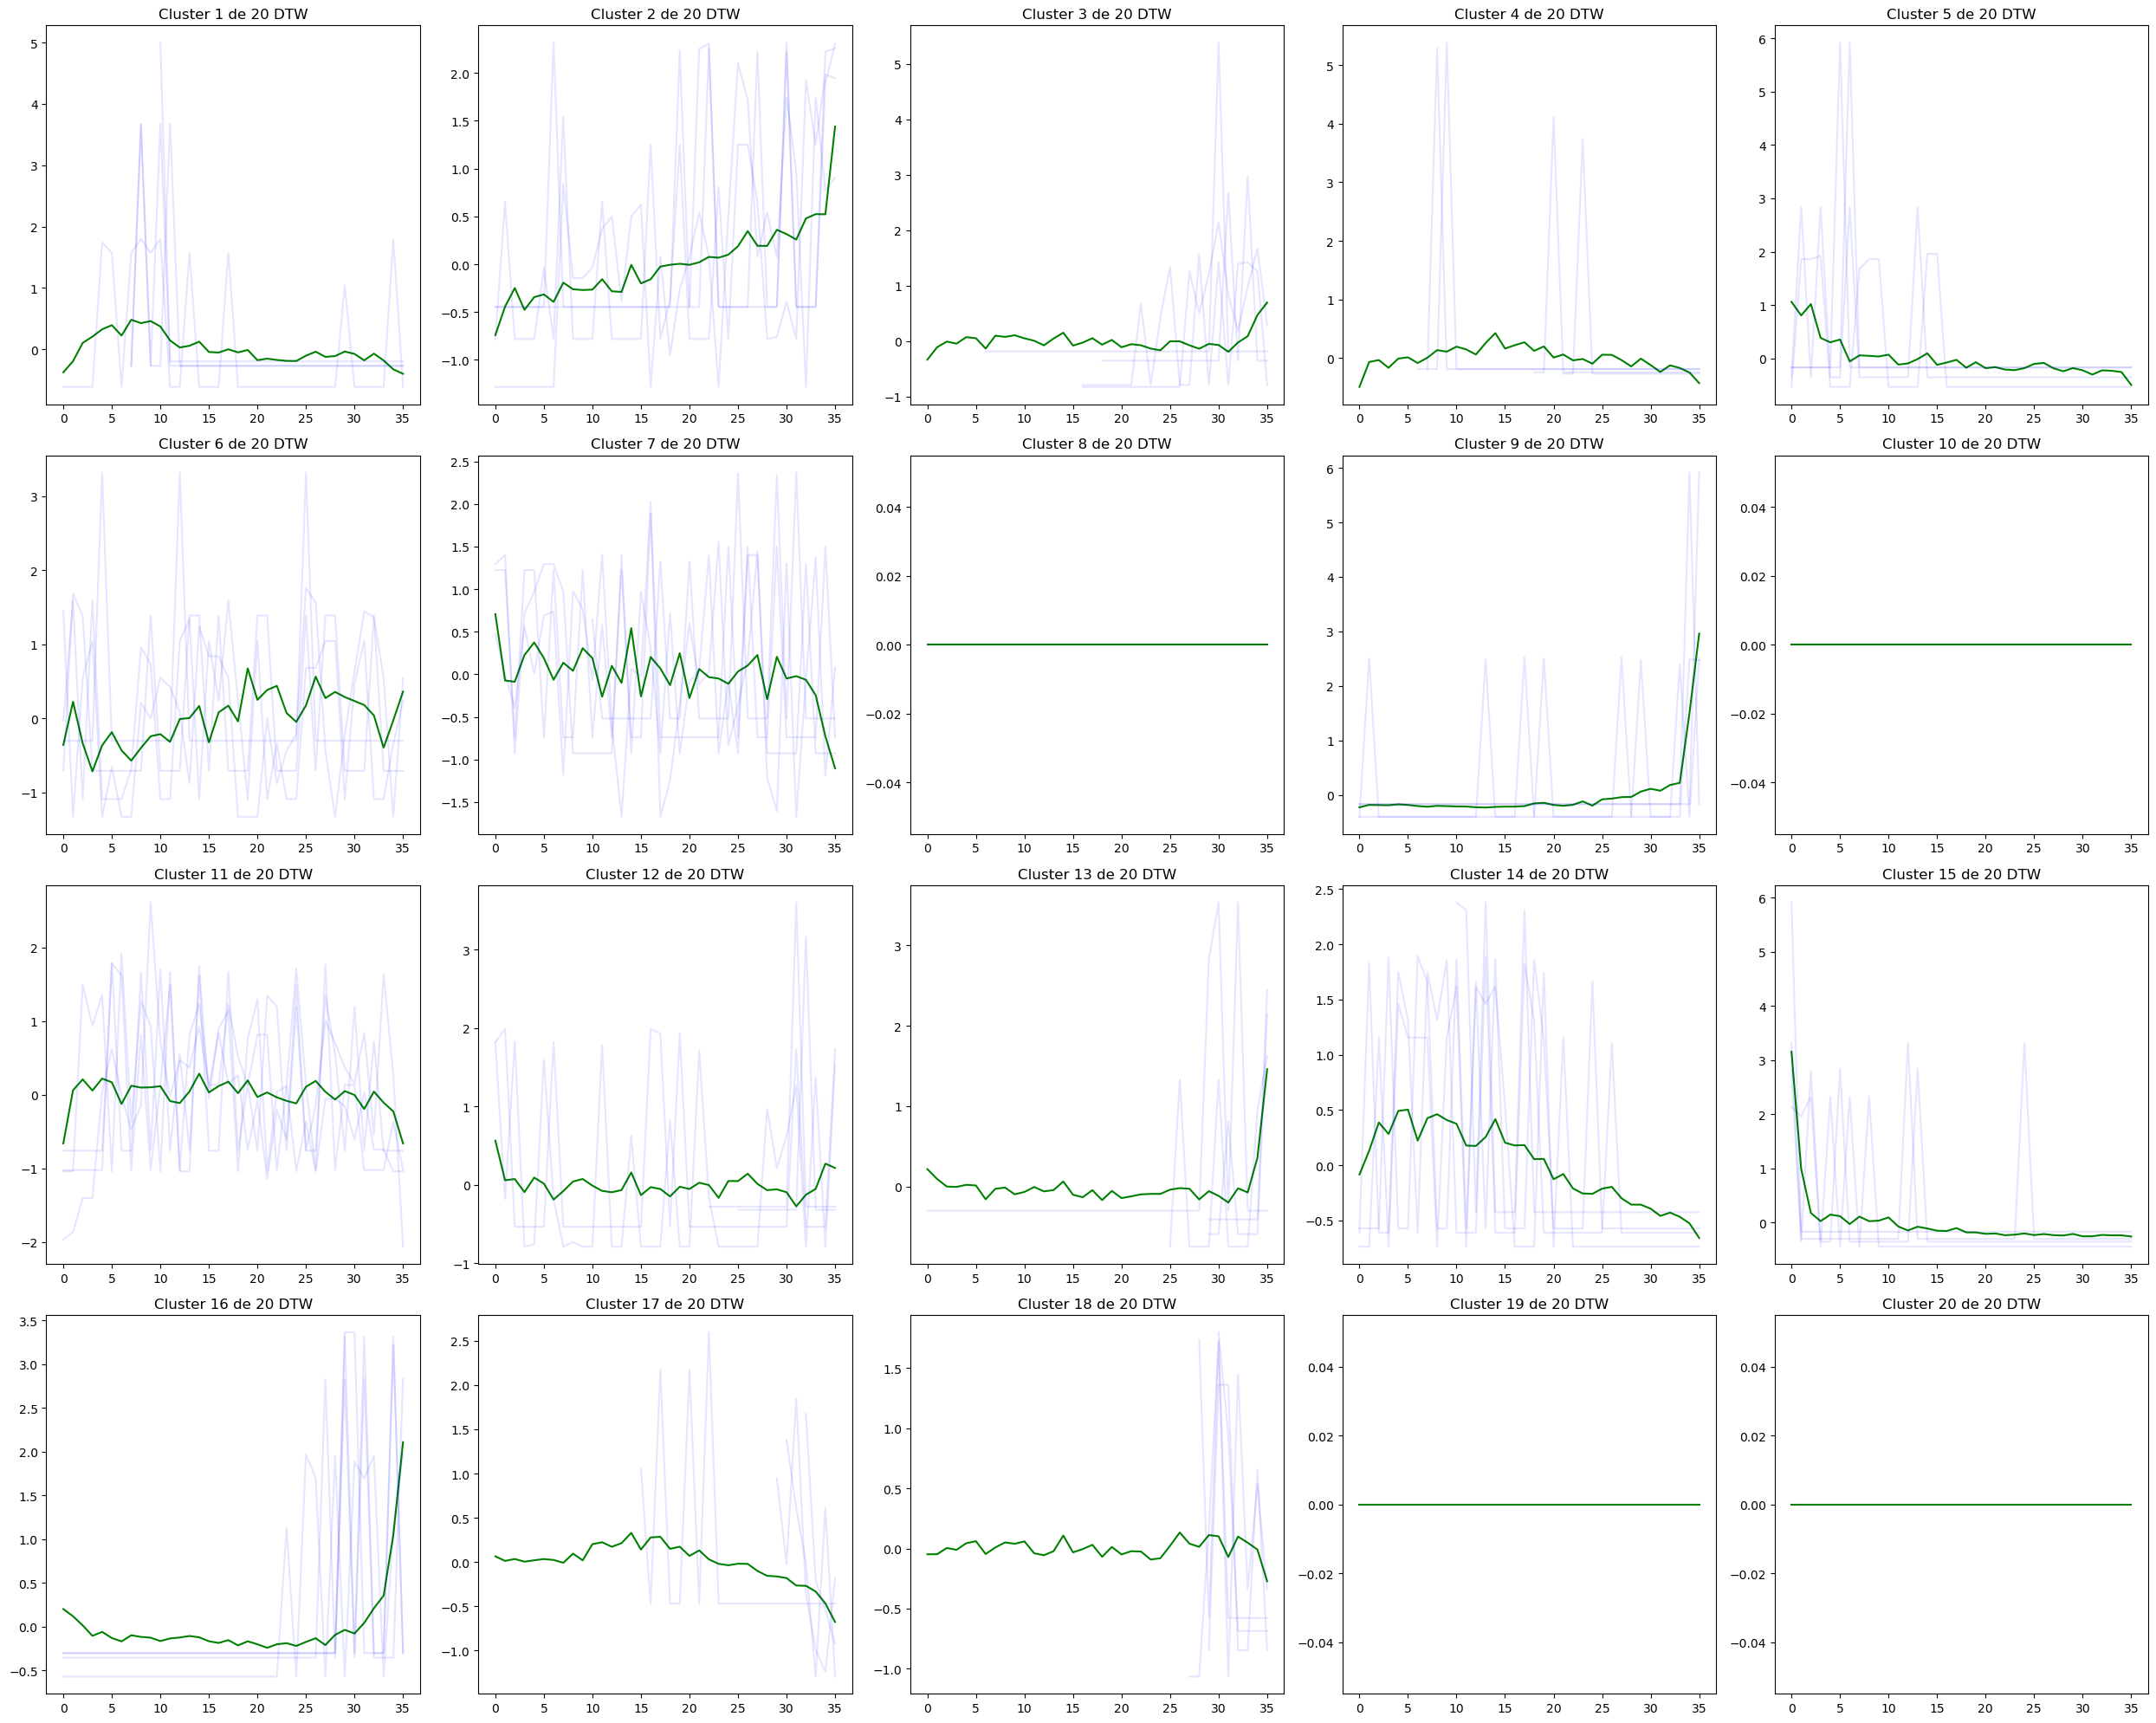

In [99]:
sample = 100

fig, axs = plt.subplots(4, 5, figsize=(25, 20))

y_pred = x_clusters_dtw

for j in range(clusters[0]):
    axs[j//5, j%5].plot(model.cluster_centers_[j].ravel(), color='green')
    axs[j//5, j%5].set_title(f"Cluster {j+1} de {clusters[0]} DTW")
    try:
        dibu_sample = dibu[dibu['cluster']==j].sample(min(dibu_sample.shape[0],sample), random_state=42)
    except:
        continue
    
    for s in range(min(dibu_sample.shape[0],sample)):
        axs[j//5, j%5].plot(dibu_sample.iloc[s,3:].values, color='blue', alpha=0.1)

plt.tight_layout()

plt.show()

In [53]:
print(f"{fase:-^100}")
print(f"{'FINALIZA':-^100}\n\n\n")

----------------------------------------------02b_DTW-----------------------------------------------
----------------------------------------------FINALIZA----------------------------------------------



